# Classification of fetal status from cardiotography (CTG) features
Author: Ilaria Bonavita
\
Date: 06-07-2020
\
Last update: 06-07-2020

This notebook presents an approach to build a multi-class classification model of fetal status (Normal, Suspect or Pathological) from features extracted from over 2000 CTGs. The dataset used has been collected by University Hospital of Porto and is publicly available here https://archive.ics.uci.edu/ml/datasets/Cardiotocography. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Data-cleaning-and-formatting" data-toc-modified-id="1.-Data-cleaning-and-formatting-1">1. Data cleaning and formatting</a></span></li><li><span><a href="#2.-Exploratory-analysis" data-toc-modified-id="2.-Exploratory-analysis-2">2. Exploratory analysis</a></span><ul class="toc-item"><li><span><a href="#2.1-Principal-Component-Analysis" data-toc-modified-id="2.1-Principal-Component-Analysis-2.1">2.1 Principal Component Analysis</a></span></li></ul></li><li><span><a href="#3.-Training-the-model" data-toc-modified-id="3.-Training-the-model-3">3. Training the model</a></span><ul class="toc-item"><li><span><a href="#3.1-Some-diagnostic-plots" data-toc-modified-id="3.1-Some-diagnostic-plots-3.1">3.1 Some diagnostic plots</a></span></li></ul></li><li><span><a href="#4.-Results" data-toc-modified-id="4.-Results-4">4. Results</a></span><ul class="toc-item"><li><span><a href="#4.1-Variable-importance-and-re-training-of-important-variables" data-toc-modified-id="4.1-Variable-importance-and-re-training-of-important-variables-4.1">4.1 Variable importance and re-training of important variables</a></span></li></ul></li></ul></div>

In [14]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from random import seed
from random import random
from sklearn import preprocessing
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
import scipy.stats as ss
import timeit
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import copy 
import warnings

from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import  ParameterGrid
from sklearn.metrics import plot_confusion_matrix
import pickle

warnings.filterwarnings('ignore')

## 1. Data cleaning and formatting

In this section some standard data cleaning and sanity checks are performed.

In [5]:
DATA_PATH = "./data/CTG.xls"

In [6]:
# read xls
df = pd.read_excel(DATA_PATH, sheet_name='Raw Data')

# remove first empty row and last three inconsistent rows
df = df.drop([0, *range(len(df)-3,len(df))], axis=0)

# check that column SegFile has unique values 
df.SegFile.nunique()==len(df)

True

In [7]:
print(df.shape)

# set segFile as index
df.SegFile = df.SegFile.str.rstrip('.txt')
df.set_index('SegFile', inplace=True)

# check missing values
df.isnull().values.any()

(2126, 40)


False

In [7]:
df.head()

,FileName,Date,b,e,LBE,LB,AC,FM,UC,ASTV,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
SegFile,,,,,,,,,,,,,,,,,,,,,
CTG0001,Variab10.txt,1996-12-01,240.0,357.0,120.0,120.0,0.0,0.0,0.0,73.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
CTG0002,Fmcs_1.txt,1996-05-03,5.0,632.0,132.0,132.0,4.0,0.0,4.0,17.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
CTG0003,Fmcs_1.txt,1996-05-03,177.0,779.0,133.0,133.0,2.0,0.0,5.0,16.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
CTG0004,Fmcs_1.txt,1996-05-03,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,16.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
CTG0005,Fmcs_1.txt,1996-05-03,533.0,1147.0,132.0,132.0,4.0,0.0,5.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0


The CTGs have been collectec across several years. Different machines and processing tools may have been used. I add a column 'Year' extracted from the date to later examine whether it is a potential confunding effect.

In [8]:
# check if year may be a confunding effect
df['Year'] = [ ts.year for ts in df.Date]

df.Year.value_counts()

1996    1174
1997     330
1995     313
1998     253
1980      56
Name: Year, dtype: int64

The features identified by the experts (according to standardized guidelines) to asses the fetal status are 21 are listed in the original xls file and reference paper. Due to lack of clear information about the other features I follow the experts indication in the selection of the features.

In [9]:
# separate features from response and other metadata

features = ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV',
            'Width', 'Min', 'Max','Nmax', 'Nzeros', 'Mode', 'Mean', 'Median','Variance', 'Tendency']
labels = 'NSP'

In [11]:
df[features].describe().loc[['mean','std'],:].T

,mean,std
LB,133.303857,9.840844
AC,2.722484,3.560850
FM,7.241298,37.125309
UC,3.659925,2.847094
DL,1.570085,2.499229
DS,0.003293,0.057300
DP,0.126058,0.464361
ASTV,46.990122,17.192814
MSTV,1.332785,0.883241
ALTV,9.846660,18.396880


The features present very different means and stds as they are in different scales. Depending on the approach chosen to modelling, feature normalization may be needed. 

Note that the attributes 'DS' has very low variance. We can check that is different from zero only in 7 samples we can therefore consider to remove it from the features set.

In [11]:
pd.crosstab(df['DS'], df[labels])

NSP,1.0,2.0,3.0
DS,,,
0.0,1654,295,170
1.0,1,0,6


## 2. Exploratory analysis

The classes are highly imbalanced towards the class Normal. This may affect the performances of the model in predicting the minority classes; in this case techiniques like undersampling may be considered.

In [12]:
# rename labels for better readibility
NSPmap = {1:'Normal',2:'Suspect',3:'Pathologic'}
df.NSP = df.NSP.map(NSPmap)

In [13]:
l1 = list(df[labels].value_counts())
l2 = list(df[labels].value_counts(normalize=True))
pd.DataFrame(list(zip(l1,l2)), columns=['count','percentage'], index=NSPmap.values())

,count,percentage
Normal,1655,0.778457
Suspect,295,0.138758
Pathologic,176,0.082785


I convert the two categorical variables with one-hot econding to be able to compute the Pearson correlation matrix.

In [14]:
# create a df object for corr plot and dummy variables
df_corr = df[features + [labels] + ['Year']]
df_corr = pd.concat([df_corr, pd.get_dummies(df_corr['Year'], prefix='Year')], axis= 1)
df_corr = pd.concat([df_corr, pd.get_dummies(df_corr[labels], prefix='class')], axis= 1)
df_corr = df_corr.drop(['Year',labels], axis = 1)

(29.0, 0.0)

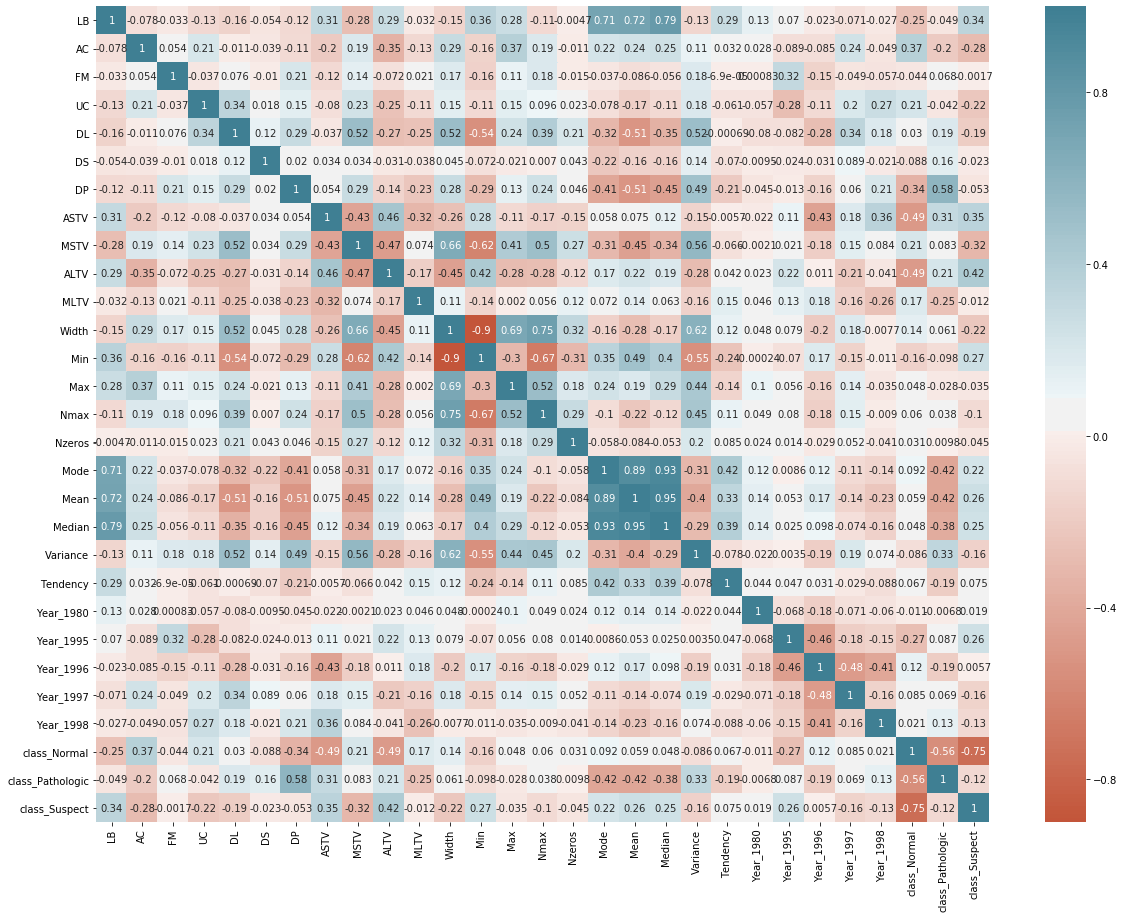

In [15]:
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20,15))
X_corr = df_corr.corr()
ax = sns.heatmap(X_corr, annot=True, cmap=sns.diverging_palette(20, 220, n=200)) 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Features Mean, Mode, Median are strongly correlated as expected by the definition of these metrics. Also Width, Min, Max and NMax  have middle to high correlation. Another block of medium correlation can be seen between Mode,Mean and Median and LB (fetal heartrate baseline value). Interestingly, features related with the time of recorded abnormal movements (ASTV, MSTV ALTV, MLTV) do not show high intra-correlation.

The feature Year doesn't correlate with the features from the feature set without taking any corrective action.

Below I show the pairplot of some features considered important by the expert divided by assisgned class. This should give an idea on how these features relate and whether the distributions of the 3 classes are visibly separable or present high overlap.

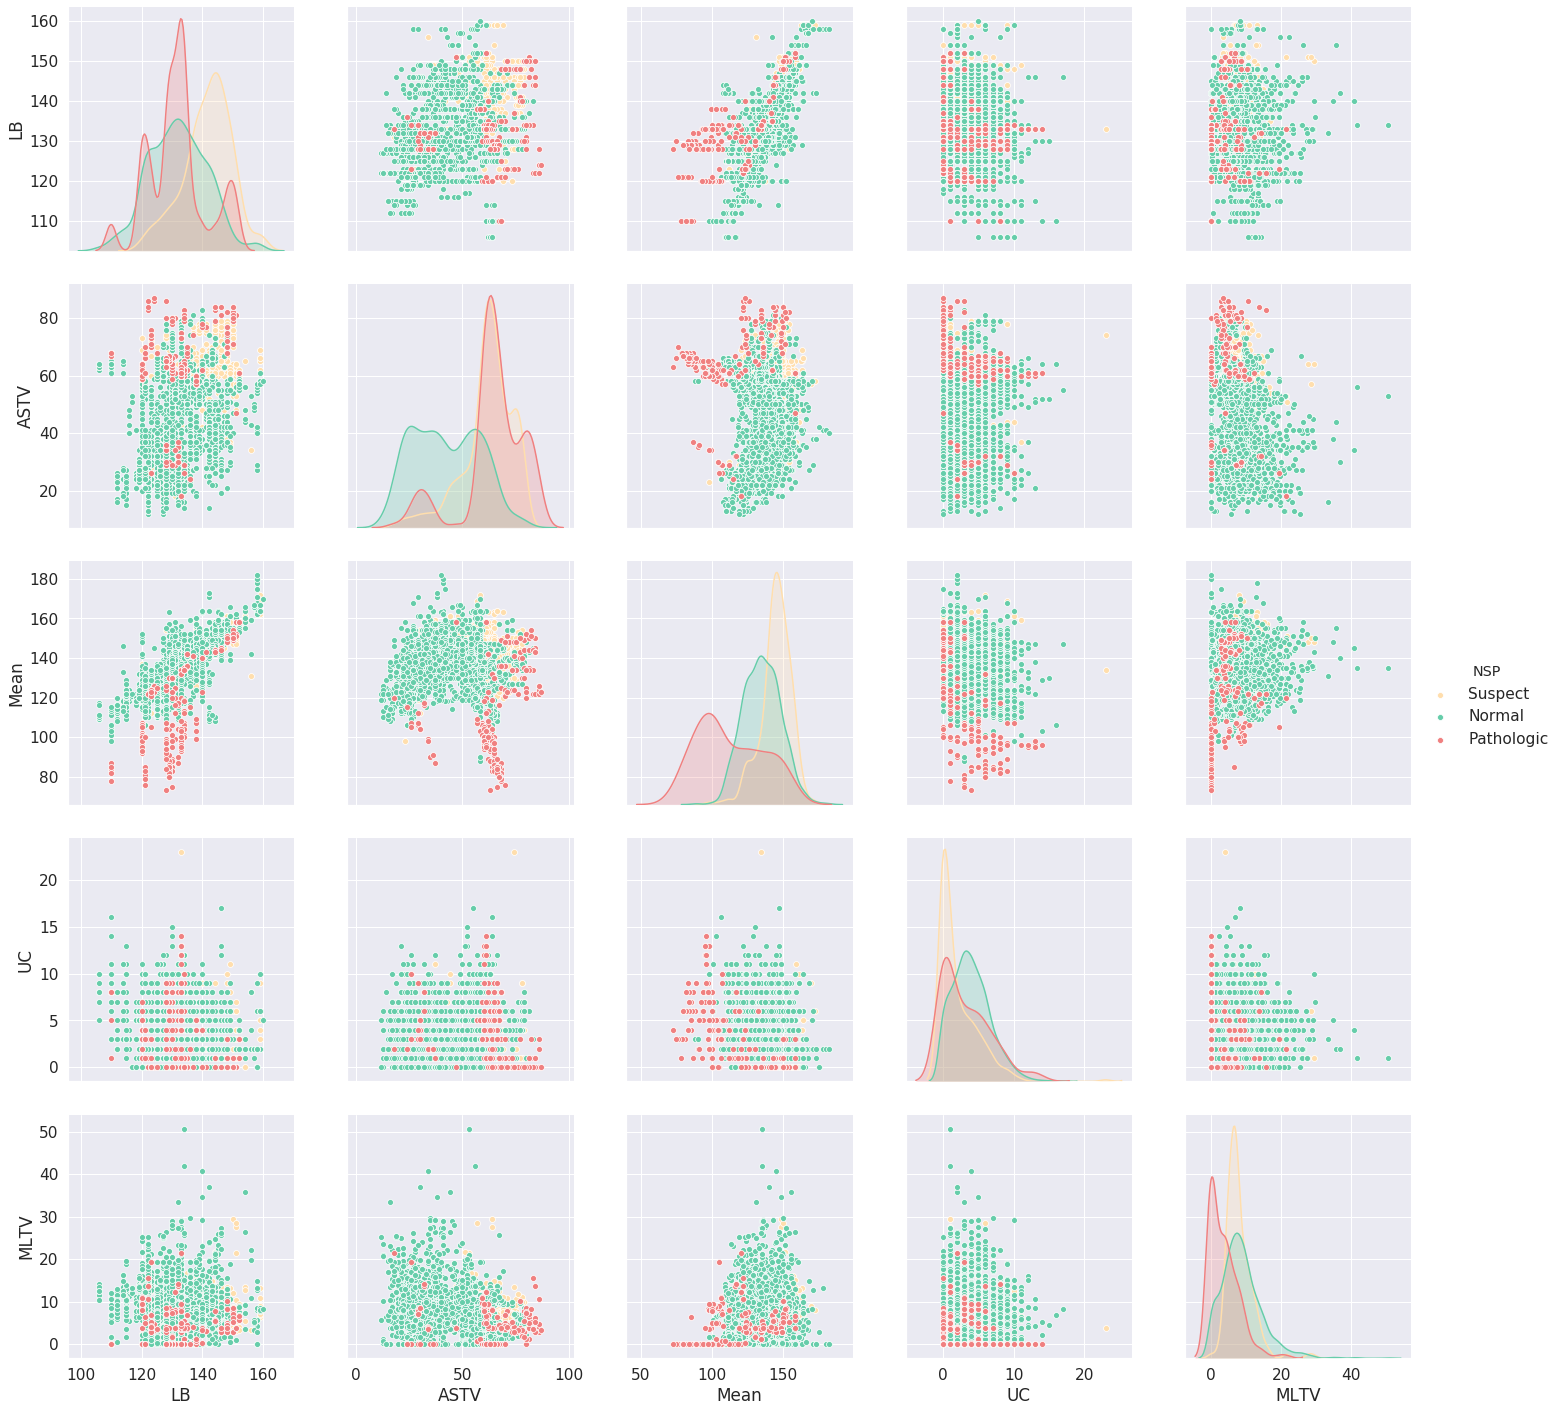

In [494]:
feat_toplot = ['LB', 'ASTV', 'Mean','UC','MLTV']
col_dict = {'Normal':'mediumaquamarine', 'Suspect':'navajowhite', 'Pathologic':'lightcoral'}

sns.pairplot(data = df, vars = feat_toplot,hue = labels, height=4, aspect=1,palette=col_dict)

Below I plot the distributions of the features, separatedly for class. This is for visually inspecting some properties of the features. If features present little overlap between classes, we may hypothesyse that these features will be good predictors of the fetus status. Some variables cannot be easily visualized, a log transformazion or similar may improve visualization (to do).

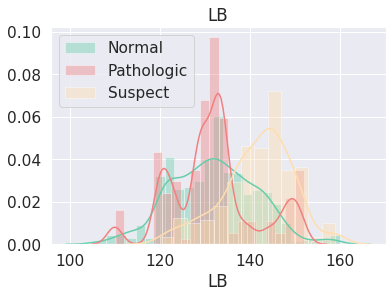

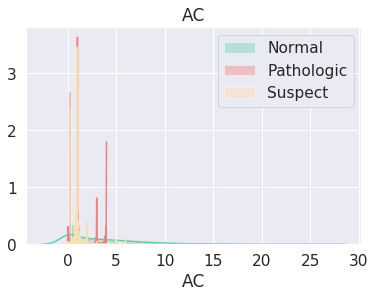

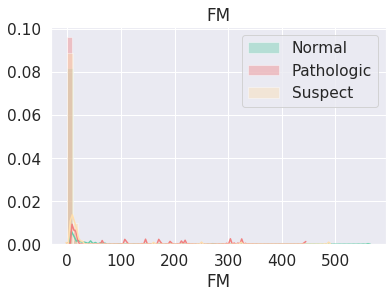

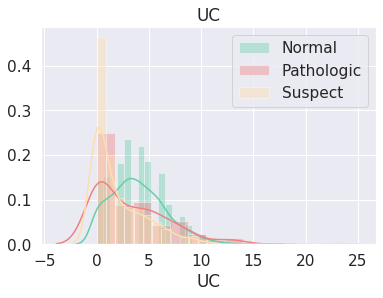

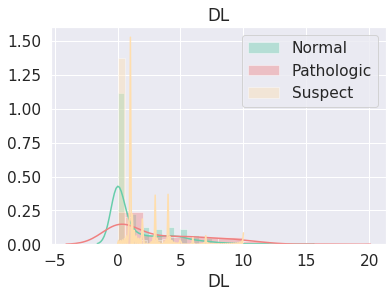

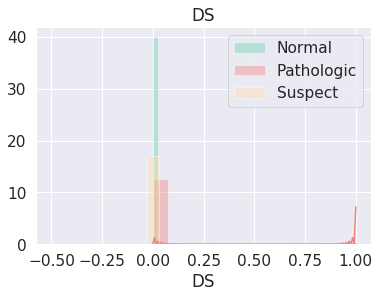

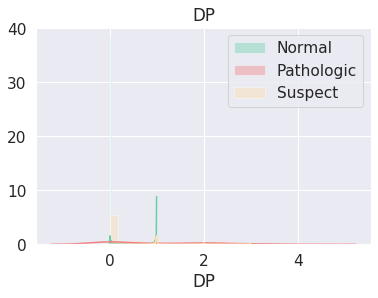

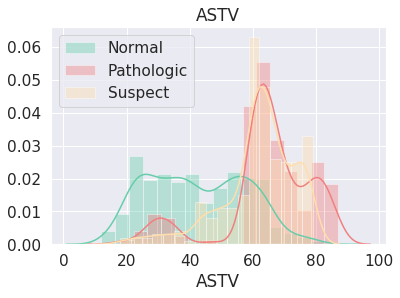

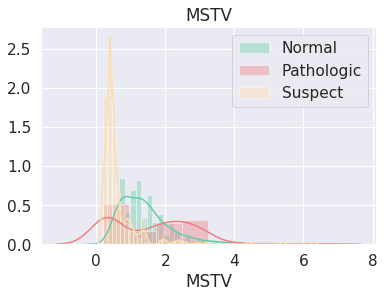

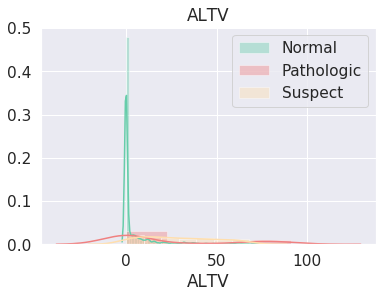

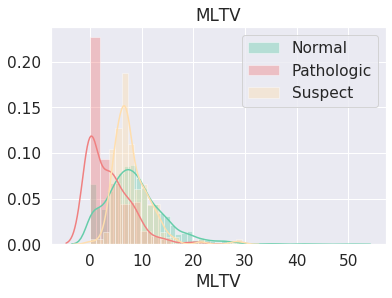

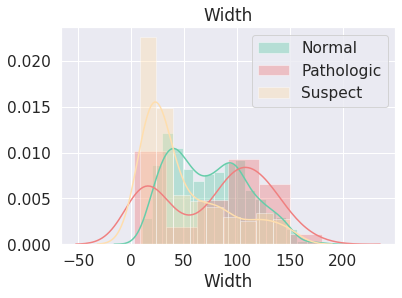

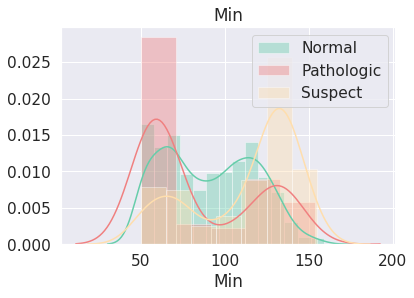

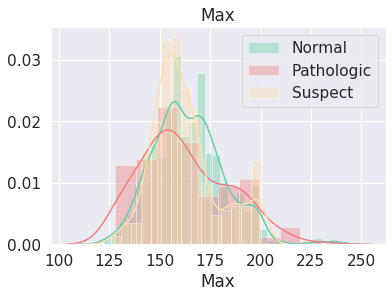

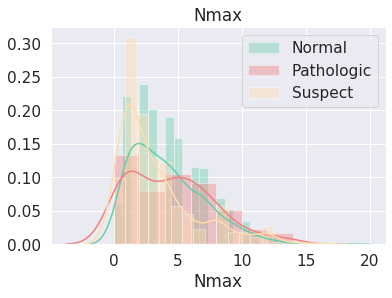

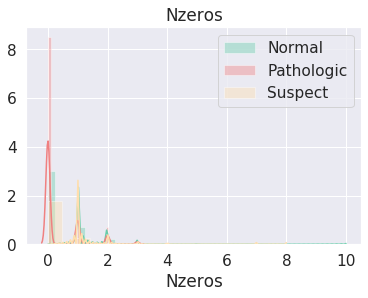

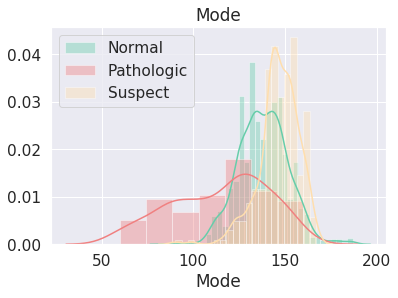

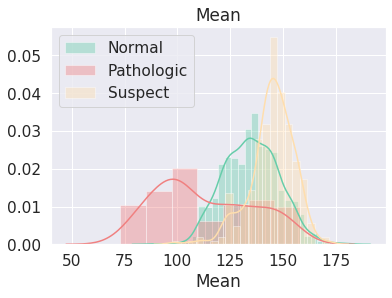

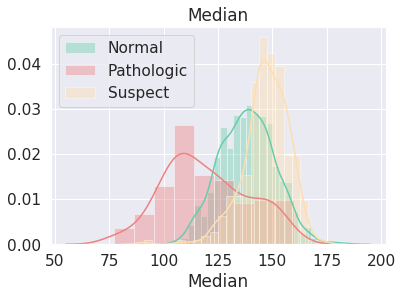

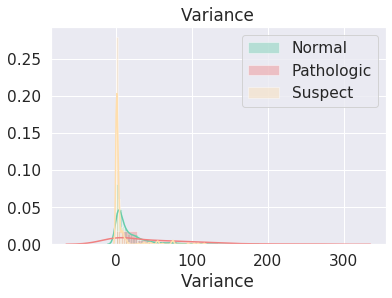

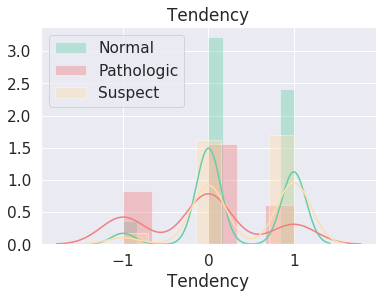

In [496]:
for i in features:
    plt.figure()
    sns.distplot(df[i].loc[df['NSP']=='Normal'], label = 'Normal', color='mediumaquamarine')
    sns.distplot(df[i].loc[df['NSP']=='Pathologic'], label = 'Pathologic', color='lightcoral')
    sns.distplot(df[i].loc[df['NSP']=='Suspect'], label = 'Suspect', color='navajowhite')
    plt.title(i)
    plt.legend()

### 2.1 Principal Component Analysis 

For having an idea of the inner dimensionality of the problem and a visualization of the samples in a lower dimensional space, I perform a PCA on the scaled dataset.
The PCA plots in dimensions 1-2 and 3-4 allow to observe a clear separation between the samples of Normal and Pathological classes. As expected, the Suspect group is less clearly defined and samples appear more 'shuffled' with the Normal class. 
Although the first 4 dimenions seem to offer a good division between Normal and Pathologic, they explain around 60% of the variance in the data. This suggests that for identifying the Suspect class, probably more dimensions are needed. 11 components explain 90% of the variability in the data.

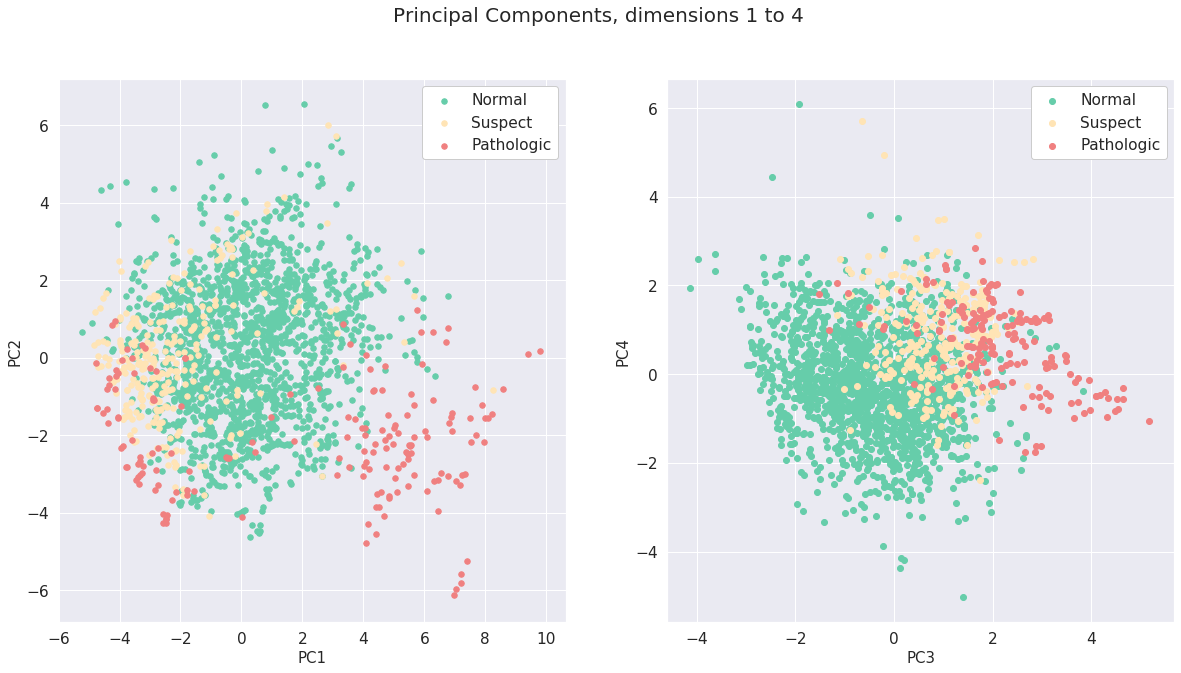

In [474]:
X = df[features].values
y = df[labels].values

X = StandardScaler().fit_transform(X)

pca = PCA(n_components=len(features))
principalComponents = pca.fit_transform(X)
principal_df = pd.DataFrame(data = principalComponents[:,0:4],
                           columns = ['PC1','PC2','PC3','PC4'])
principal_df = principal_df.set_index(df.index)
pc12 = pd.concat([principal_df[['PC1','PC2']], df[labels]], axis = 1)
pc34 = pd.concat([principal_df[['PC3','PC4']], df[labels]], axis = 1)



fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Principal Components, dimensions 1 to 4', fontsize=20)
ax1.set_xlabel('PC1', fontsize = 15)
ax1.set_ylabel('PC2', fontsize = 15)
targets = NSPmap.values()
colors = ['mediumaquamarine', 'moccasin', 'lightcoral']
for target, color in zip(targets,colors):
    indicesToKeep = df[labels] == target
    ax1.scatter(pc12.loc[indicesToKeep, 'PC1']
               , pc12.loc[indicesToKeep, 'PC2']
                , c = color
                , s = 30)
ax1.legend(targets, facecolor='white', framealpha=1)
ax2.grid(b=True, which='major', linestyle='-')


ax2.set_xlabel('PC3', fontsize = 15)
ax2.set_ylabel('PC4', fontsize = 15)
targets = NSPmap.values()
colors = ['mediumaquamarine', 'moccasin', 'lightcoral']
for target, color in zip(targets,colors):
    indicesToKeep = df[labels] == target
    ax2.scatter(pc34.loc[indicesToKeep, 'PC3']
               , pc34.loc[indicesToKeep, 'PC4']
                , c = color)
ax2.grid(b=True, which='major', linestyle='-')

ax2.legend(targets,facecolor='white', framealpha=1)

plt.savefig('pcaplot.png',  bbox_inches='tight')

[0.28696544 0.16586654 0.08717829 0.07086558 0.05526271 0.04943312
 0.04541082 0.04150044 0.03594918 0.03181617 0.02914537 0.02368792
 0.01935385 0.01604807 0.01340735 0.01154134 0.00693426 0.00601858
 0.00235513 0.00125985 0.        ]


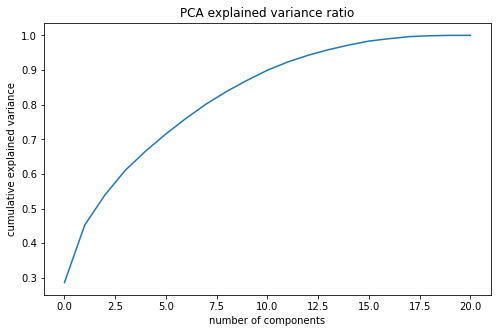

In [16]:
np.set_printoptions(suppress=True)
print(pca.explained_variance_ratio_)
plt.figure(figsize = (8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("PCA explained variance ratio")
plt.show()

In [17]:
np.cumsum(pca.explained_variance_ratio_)

array([0.28696544, 0.45283198, 0.54001027, 0.61087584, 0.66613856,
       0.71557168, 0.76098249, 0.80248293, 0.83843211, 0.87024828,
       0.89939365, 0.92308157, 0.94243543, 0.9584835 , 0.97189084,
       0.98343218, 0.99036644, 0.99638502, 0.99874015, 1.        ,
       1.        ])

In [18]:
print("Number of components explaining 90% of variance: ")
next(i for i,x in enumerate(np.cumsum(pca.explained_variance_ratio_)>0.9) if x == True)

Number of components explaining 90% of variance: 


11

Looking at the most important features in PC1 and PC2, I cannot see a straightforward interpretation of these two dimensions. Interpreation form an expert or better understading of the features could help with this....

In [19]:

feat_importance_pc1 =pd.DataFrame(abs(pca.components_)[0],
                                  index=range(len(features)), columns =['eigenvecPC1'])

feat_importance_pc1.insert(0,'features1',pd.DataFrame(features))
feat_importance_pc2 =pd.DataFrame(abs(pca.components_)[1],
                                  index=range(len(features)), columns =['eigenvecPC2'])
feat_importance_pc2.insert(0,'features2',pd.DataFrame(features))
                                 
feat_importance_pc1 = feat_importance_pc1.sort_values(by='eigenvecPC1', ascending=False).reset_index(drop=True)
feat_importance_pc2 = feat_importance_pc2.sort_values(by='eigenvecPC2', ascending=False).reset_index(drop=True)

pd.merge(feat_importance_pc1,feat_importance_pc2, left_index=True, right_index=True)

,features1,eigenvecPC1,features2,eigenvecPC2
0,Min,0.334250,Max,0.380683
1,Width,0.317149,Median,0.380392
2,MSTV,0.315329,Mode,0.370651
3,Mean,0.309642,Mean,0.327805
4,Variance,0.288697,LB,0.286661
5,Median,0.274489,Width,0.282456
6,DL,0.272351,AC,0.261029
7,Mode,0.260410,Nmax,0.241259
8,Nmax,0.254572,Tendency,0.229701
9,LB,0.224372,Min,0.141143


## 3. Training the model

I choose a random forest classifier for this multi-class prediction problem. Steps executed are the following:
1. I divide the dataset in train and test with a 70-30% split.
2. I initialize a model, choosing some parameters based on the gathered knowledge on the data and leaving the default values for other parameters.
3. I use the train portion of the data to hypertune parameters whose tuning is more critical in random forest models. I perform hypertuning through grid-search and using the out-of-bag score as criteria for optimization.
4. I change the default parameters of the initial model with the "best" parameters obtained in step 3.
5. I use the fine-tuned model for prediction on the test set
 


In [15]:
#set seed
RFSEED=111
seed(RFSEED)

# define the random forest
rf = RandomForestClassifier( oob_score=True, 
                            class_weight='balanced', random_state=RFSEED)


# split data in train and test set (30%) stratified according to the label
X = df[features]
y = df[labels]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,
                                                          test_size = 0.3)

In [16]:
# define grid of parameters for hyper-parameters tuning

n_estimators = [int(x) for x in np.linspace(start = 80, stop = 800, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
min_samples_leaf = [1, 2, 4]
max_features = [None , 'sqrt']

param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features}

In [17]:
# create df for exploring results after

n_config = len( ParameterGrid(param_grid))
header = sorted(ParameterGrid(param_grid)[0].keys()) 
header.append('oob_score')

results_df = pd.DataFrame(None, index= range(n_config), columns = header)

In [18]:
len(ParameterGrid(param_grid))

660

The cell below perform the search of the best configuration of parameters.

DO NOT RUN if not necessary -It takes around 20 minutes to complete

In [283]:


# list for saving all the scores
best_score = -1

start_time = timeit.default_timer()

for i, g in enumerate(ParameterGrid(param_grid)):
    rf.set_params(**g)
    rf.fit(X_train,y_train)
    
    # save in results df
    param = list(g.values())
    param.append(rf.oob_score_)
    results_df.loc[i] = param
    
    # save if best
    if rf.oob_score_ > best_score:
        print(i)
        best_score = rf.oob_score_
        best_grid = g

elapsed = timeit.default_timer() - start_time
    

print( "OOB: %0.5f" % best_score )
print( "Grid:", best_grid)

0
1
2
3
4
5
8
60
62
64
71
75
OOB: 0.95161
Grid: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 480}


In [284]:
print("Time needed for parameters hypertuning (minutes): ", elapsed/60)

Time needed for parameters hypertuning (minutes):  19.06388679988328


In [285]:
#results_df.to_csv('./results_df_none.csv', index=False)

In [286]:
rf_best = rf.set_params(**best_grid)

# save the model
pickle.dump( rf_best , open('rf_best.p', 'wb'))

# re-train on the all dataset
rf_best = rf_best.fit(X_train, y_train)

### 3.1 Some diagnostic plots

The plots below show how the oob score changes as a function of some paramters.

In [445]:
# define function for plotting 

def plot_oob_scores_param(oob_df, param):
    
    param_df = oob_df[[param, 'oob_score', 'max_features']]
    param_df.loc[param] = param_df[param].replace(to_replace=[None], value=200, inplace=True)
    param_df.loc['max_features'] = param_df['max_features'].replace(to_replace=[None],
                                                                  value='all', inplace=True)
    param_df = param_df.reset_index(drop=True)
    param_df = param_df.drop(param_df.tail(2).index)
    
    pldf = pd.DataFrame(None, index= range(len(param_df[param].value_counts())*2), 
                        columns = [param,'max_features','mean_oob_score'])
    
    for i, f in enumerate(param_df.groupby([param,'max_features'])):
        pldf.loc[i][param] = f[0][0]
        pldf.loc[i]['max_features'] = f[0][1]
        pldf.loc[i]['mean_oob_score'] = f[1]['oob_score'].mean()
    
    
    sns.catplot(x=param, y="mean_oob_score", hue="max_features",
            palette={"all": "orange", "sqrt": "m"},
            kind="point", data=pldf, height=5, aspect=2)
    plt.title('mean oob scores as function of ' + param )
    plt.show()

The first plot reports the mean oob scores as a function of the max depth of a tree (max_depth), separatedly for the cases in which max_fatures is auto (i.e. all the features considere) and sqrt (i.e. sqrt(features) considered, 4 in our case). I fix the other parameters of the grid with their best values obtained in the validation (i.e. n_estimators = 480 and min_samples_leaf = 2).

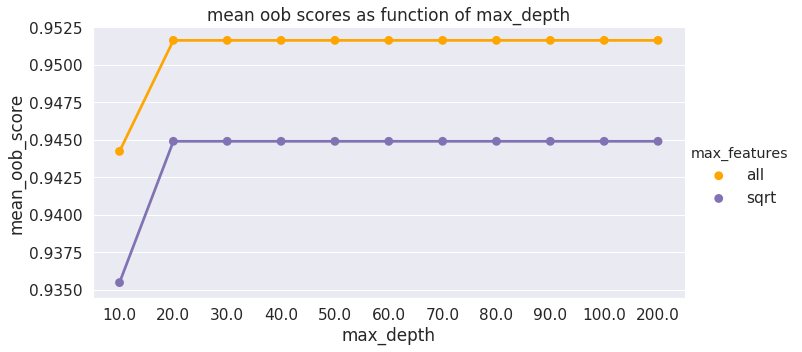

In [446]:
rsdf = results_df[(results_df.min_samples_leaf==best_grid['min_samples_leaf'])
                  & (results_df.n_estimators==best_grid['n_estimators'])]

plot_oob_scores_param(oob_df = rsdf, param = 'max_depth')

The second plot reports the mean oob scores as a function of the number of trees used (n_estimator), separatedly for the cases in which max_fatures is auto (i.e. all the features considere) and sqrt (i.e. sqrt(features) considered, 4 in our case).  I fix the other parameters of the grid with their best values obtained in the validation (i.e. n_estimators = 480 and min_samples_leaf = 2).

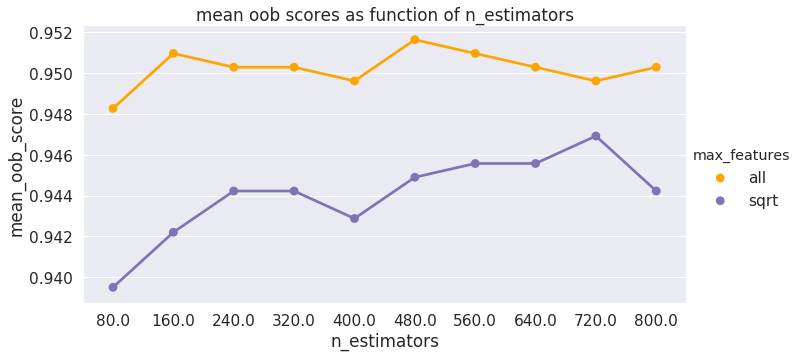

In [447]:
rsdf = results_df[(results_df.min_samples_leaf==best_grid['min_samples_leaf'])
                  & (results_df.max_depth==best_grid['max_depth'])]

plot_oob_scores_param(oob_df = rsdf, param = 'n_estimators')

## 4. Results 

Predictions on the hold-out test set show good predictions over a set of standard performance metrix. As expected Normal class achieves the best performances and Suspect the lowest. Performances on the Suspect class are the worse. Since this is the case more difficult to assess for the experts, improving the model with respect to this performance is of major interest.

From the confusion matrix we can observe the Suspect are more often misclassified as normal, suggesting that the FHR features of samples identified as Suspect is more similar to Normal than to Pathologic case (this may also indicate a conservative approach from the ostetrich that annotated the dataset).

In [287]:
y_pred= rf_best.predict( X_test)
report = classification_report(y_pred,y_test)
print(report)


              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97       499
  Pathologic       0.91      0.92      0.91        52
     Suspect       0.85      0.86      0.86        87

    accuracy                           0.95       638
   macro avg       0.91      0.92      0.91       638
weighted avg       0.95      0.95      0.95       638



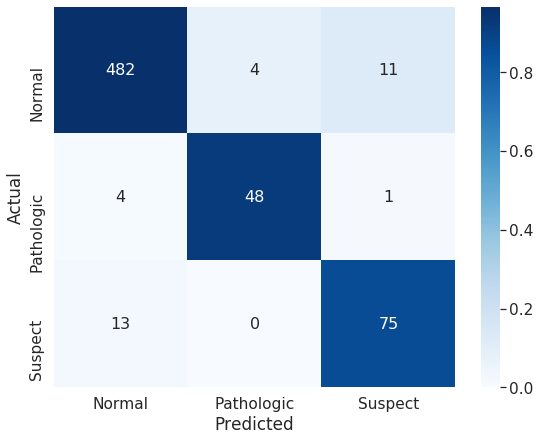

In [510]:
data = confusion_matrix(y_test, y_pred, normalize='pred')
annotation = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

fig, ax = plt.subplots(figsize=(9,7))
ax = sns.set(font_scale=1.4)#for label size
ax = sns.heatmap(df_cm, cmap= 'Blues', annot=annotation ,annot_kws={"size": 16},fmt='g')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.savefig('confmatrix.png')

### 4.1 Variable importance and re-training of important variables

In this section I extract the variable importance from the model. It can be observed that features importance decrease more greatly after the 6th (and, to a less extent, after the 7th) feature.

Using the best parameter configuration obtained before, I train a new model with a reduced features set using the 7 most important features. It can be seen that the model achieves a comparable high performances indicating that these features may be sufficient for predicting the outcome.

This information could help the experts to focus on these features in their evaluations and in the phase of extracting and processing features from the FHR signal.

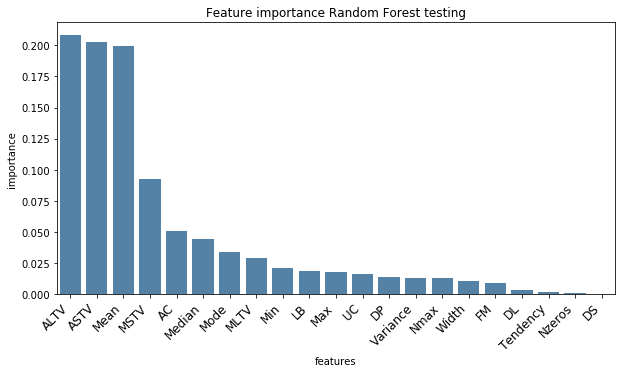

In [92]:
importance_df =pd.DataFrame(list(rf_best.feature_importances_),
                                  index=range(len(features)), columns =['importance'])
importance_df.insert(0,'features',pd.DataFrame(features))
importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10,5))
ax = sns.barplot(x='features', y='importance', color='steelblue', data=importance_df)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.title('Feature importance Random Forest testing')
plt.savefig('featimport.png', bbox_inches='tight')

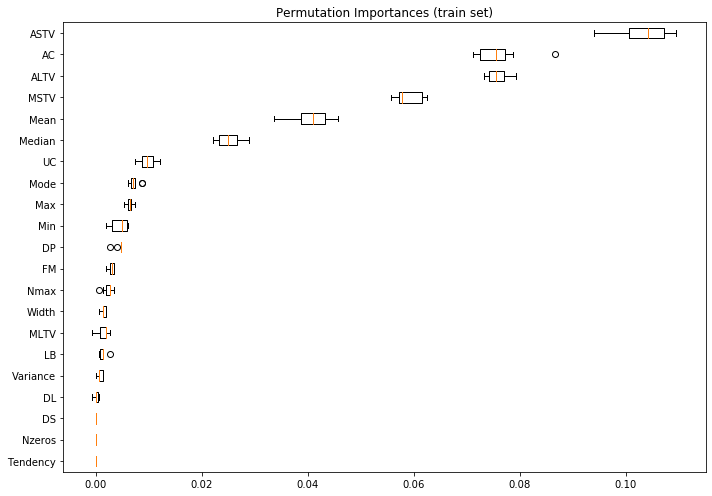

In [93]:
best_grid = {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 480}
rf_best = rf.set_params(**best_grid)

from sklearn.inspection import permutation_importance

rf_best.fit(X_train, y_train)
result = permutation_importance(rf_best, X_train, y_train, n_repeats=10,
                           random_state=RFSEED)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10,7))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

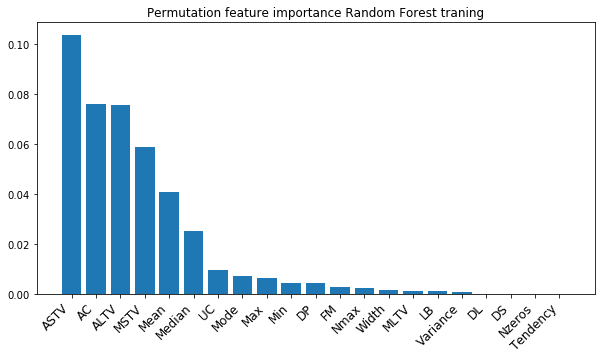

In [94]:
sorted_idx = result.importances_mean.argsort()[::-1][:len(features)]
plt.figure(figsize=(10,5))
plt.bar(height=result.importances[sorted_idx].mean(axis=1), x=X_train.columns[sorted_idx])
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.title('Permutation feature importance Random Forest traning')
plt.savefig('permfeatimpt.png')

In [483]:
# Extract the names of the most important features
important_feature_names = list(importance_df.features.iloc[0:7].values)
print(important_feature_names)
# Create training and testing sets with only the important features
X_train_important = X_train[important_feature_names]
X_test_important = X_test[important_feature_names]


print('Important train features shape:', X_train_important.shape)
print('Important test features shape:', X_test_important.shape)

['Mean', 'MSTV', 'ASTV', 'ALTV', 'Median', 'AC', 'DP']
Important train features shape: (1488, 7)
Important test features shape: (638, 7)


In [484]:
# define the random forest
rf_imp = RandomForestClassifier( oob_score=True, 
                            class_weight='balanced', random_state=RFSEED)
rf_imp = rf_imp.set_params(**best_grid)

rf_imp = rf_imp.fit(X_train_important, y_train)

In [485]:
rf_imp.oob_score_

0.9341397849462365

In [486]:
seed(RFSEED)
y_pred_imp= rf_imp.predict( X_test_important)
report_imp = classification_report(y_pred_imp,y_test)

In [487]:
print(report_important)

              precision    recall  f1-score   support

      Normal       0.96      0.97      0.96       494
  Pathologic       0.91      0.91      0.91        53
     Suspect       0.85      0.82      0.84        91

    accuracy                           0.94       638
   macro avg       0.91      0.90      0.90       638
weighted avg       0.94      0.94      0.94       638



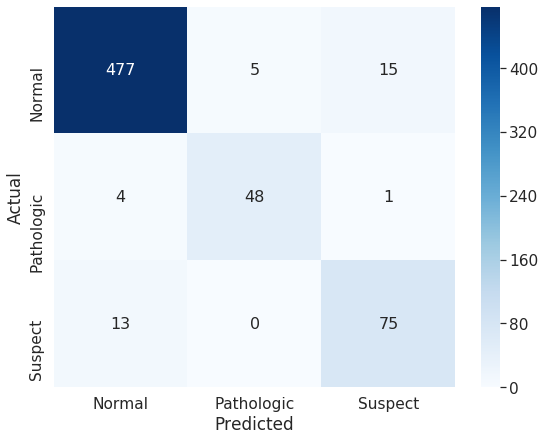

In [488]:
data = confusion_matrix(y_test, y_pred_imp)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

fig, ax = plt.subplots(figsize=(9,7))
ax = sns.set(font_scale=1.4)#for label size
ax = sns.heatmap(df_cm, cmap= 'Blues', annot=True,annot_kws={"size": 16},fmt='g')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.savefig('confmatrix_imp.png')